In [44]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse.linalg

from sklearn.utils.extmath import randomized_svd

import hapod as hp


(10000, 1000)


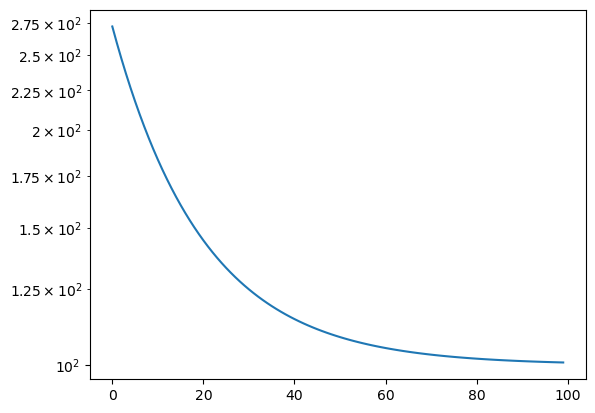

In [45]:
dtype = np.float64
n_rows = 10000
n_cols = 1000
rank_max = 100
chunk_rank_max = rank_max // 2
n_chunks = hp.get_n_chunks_balanced(n_cols, n_chunk_max_cols=chunk_rank_max)

# Xs = np.array_split(X, n_chunks, axis=1)
ranks = np.arange(0, n_cols)
s_true = 100 * np.exp(np.exp(-ranks/20))
U_true, _ = np.linalg.qr(np.random.rand(n_rows, n_cols))
V_true, _ = np.linalg.qr(np.random.rand(n_cols, n_cols))
X = U_true @ np.diag(s_true) @ V_true.T
print(X.shape)

Xs = np.array_split(X, n_cols, axis=1)
Xs = hp.make_chunks(Xs,
                    ".",
                    n_chunks=n_chunks,
                    serializer=hp.InMemorySerializer(),
                    # randomizer_rng=np.random.default_rng()
                    )

plt.semilogy(s_true[:rank_max])
plt.show()
plt.close()

verbose = False

In [46]:
U_np, s_np = hp.get_pod(X, rank_max)

In [47]:
U_econ, s_econ, _ = scipy.sparse.linalg.svds(X, k=rank_max)

sorter = np.flip(np.argsort(s_econ))
U_econ = U_econ[:, sorter]
s_econ = s_econ[sorter]

In [48]:
U_rand, s_rand, _ = randomized_svd(X, 
                                    n_components=rank_max, 
                                    n_oversamples=0, 
                                    random_state=42)

In [49]:
U_hp_inmemory, s_hp_inmemory = hp.hapod(Xs,
                      chunk_rank_max=chunk_rank_max,
                      serializer=hp.InMemorySerializer(),
                      verbose=verbose,
                      )

In [50]:
# U_hp_file, s_hp_file = hp.hapod(Xs,
#                       chunk_rank_max=chunk_rank_max,
#                                 verbose=verbose,
#                                 )

In [51]:
# random_samples = np.random.choice(n_cols, 
#                                   size=rank_max*2, 
#                                   replace=False)
# # Xs_rand = np.array_split(X[:, random_samples], 1, axis=1)
# Xs_rand = np.array_split(X[:, random_samples], len(random_samples), axis=1)
# Xs_rand = hp.make_chunks(Xs_rand,
#                     ".",
#                     n_chunks=n_chunks,
#                     serializer=hp.InMemorySerializer(),
#                     randomizer_rng=np.random.default_rng()
#                     )
# U_hp_rand, s_hp_rand = hp.hapod(Xs_rand,
#                       chunk_rank_max=chunk_rank_max,
#                       serializer=hp.InMemorySerializer(),
#                       verbose=verbose,
#                       )

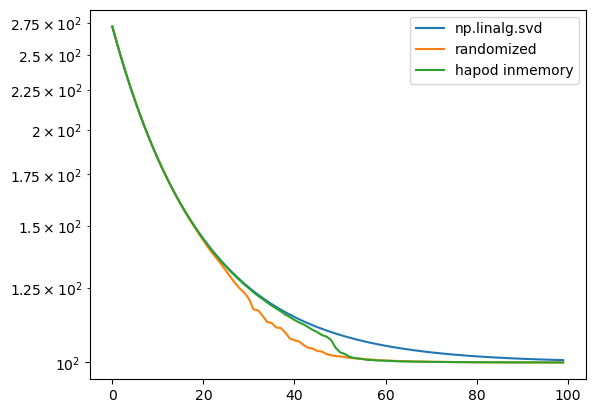

In [52]:
plt.semilogy(s_np, label="np.linalg.svd")
# plt.semilogy(s_econ, label="econ")
plt.semilogy(s_rand, label="randomized")
plt.semilogy(s_hp_inmemory, label="hapod inmemory")
# plt.semilogy(s_hp_file, label="hapod file")
# plt.semilogy(s_hp_rand, label="hapod rand")

plt.legend()

plt.show()
plt.close()

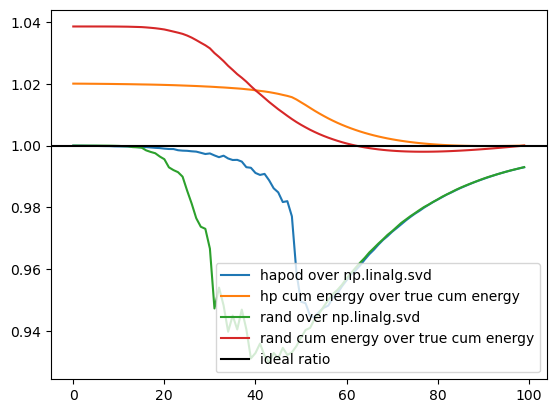

In [57]:
plt.plot(s_hp_inmemory[:len(s_np)] / s_np, 
         label="hapod over np.linalg.svd")
plt.plot(hp.get_cumulative_energy_ratios(s_hp_inmemory[:len(s_np)])
         / hp.get_cumulative_energy_ratios(s_np),
         label="hp cum energy over true cum energy")
plt.plot(s_rand[:len(s_np)] / s_np, 
         label="rand over np.linalg.svd")
plt.plot(hp.get_cumulative_energy_ratios(s_rand[:len(s_np)])
         / hp.get_cumulative_energy_ratios(s_np),
         label="rand cum energy over true cum energy")

plt.axhline(1, c="black", label="ideal ratio")

plt.legend()

plt.show()
plt.close()